In [30]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from class_function_V1 import TimeSeriesAnalysis #Função que processa os dados, separando no grupo de 53 setores
import numpy as np
from pySSA.core import MSSA
from pySSA.simple import SSA


# Leitura do arquivo Excel
df_raw = pd.read_excel(r"D:\OneDrive\Organizar UFSC\Documentos\TCC\Data_set\Base de Dados.xlsx")
df_raw = df_raw.drop(['29.1 Fabricação de automóveis, camionetas e utilitários'], axis=1)

numeric_cols = df_raw.select_dtypes(include=[np.number]).columns
df_log = df_raw.copy()
df_log[numeric_cols] = np.log(df_raw[numeric_cols])

# # Criação de instância da classe TimeSeriesAnalysis=
tsa = TimeSeriesAnalysis(df_log)

#tsa.df_macro_sectors= tsa.df_macro_sectors.loc[:, ['10.1', '10.7', '13.1','17.1','19.2','19.3','20.5','22.2','23.1','23.2','24.1','24.5','26.2','26.2','26.4','27.4','28.1','28.3','28.5','28.6']]
half = len(tsa.df_macro_sectors.columns) // 2
subset1 = tsa.df_macro_sectors.iloc[:, :15]
subset2 = tsa.df_macro_sectors.iloc[:, 17:20]
subset3 = tsa.df_macro_sectors.iloc[:, 20:30]
subset4= tsa.df_macro_sectors.iloc[:, 30:]
subset2.head()


,17.2,17.3,17.4
0,4.426179,4.423653,4.253291
1,4.336523,4.381714,4.089456
2,4.426024,4.493434,4.195721
3,4.404750,4.482248,4.197466
4,4.390403,4.474548,4.152878


________________________


In [2]:
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools

class SARIMA:
    def __init__(self, df_in):
        self.df_in = df_in

    def sarima_model(self, series, order, seasonal_order):
        model = SARIMAX(series, order=order, seasonal_order=seasonal_order)
        model = model.fit()
        return model

    def calculate_metrics(self, actual, forecast):
        error = forecast - actual
        mse = np.mean(error ** 2)
        mae = np.mean(np.abs(error))
        mape = np.mean(np.abs(error / actual))
        eqa = np.sum(error ** 2)
        rmse = np.sqrt(mse)
        rrmse = rmse / np.mean(actual)
        return mse, mae, mape, eqa, rmse, rrmse
        
    def select_best_sarima_model(self, metric, test_size):
        result_df = pd.DataFrame(columns=['Setor', 'Best Metric', 'order', 'seasonal_order',
                                          'Modelo', 'MSE_In-Sample', 'EQA_In-Sample', 'RMSE_In-Sample', 'RRMSE_In-Sample',
                                          'MAE_In-Sample', 'MAPE_In-Sample', 'MSE_Out-of-Sample', 'EQA_Out-of-Sample',
                                          'RMSE_Out-of-Sample', 'MAE_Out-of-Sample', 'MAPE_Out-of-Sample'])
        result_rows = []
        self.test_size=test_size
        for col in self.df_in.columns:
            series = self.df_in[col]
            train_data = series[:-test_size]
            test_data = series[-test_size:]

            p_values = range(0, 3)  # example range, modify as needed
            d_values = range(0, 2)  # example range, modify as needed
            q_values = range(0, 3)  # example range, modify as needed
            P_values = range(0, 3)  # example range, modify as needed
            D_values = range(0, 2)  # example range, modify as needed
            Q_values = range(0, 3)  # example range, modify as needed
            seasonal_periods = [12]  # example value, modify as needed

            orders = list(itertools.product(p_values, d_values, q_values))
            seasonal_orders = list(itertools.product(P_values, D_values, Q_values, seasonal_periods))

            best_metric = np.inf
            best_model = None
            best_order = None
            best_seasonal_order = None

            for order in orders:
                for seasonal_order in seasonal_orders:
                    model = self.sarima_model(train_data, order, seasonal_order)
                    forecast_train = model.predict(start=2, end=len(train_data) - 1)
                    forecast_test = model.forecast(len(test_data))

                    if metric == 'mae':
                        current_metric = np.abs(forecast_test - test_data).mean()
                    elif metric == 'mse':
                        current_metric = ((forecast_test - test_data) ** 2).mean()
                    elif metric == 'mape':
                        current_metric = (np.abs(forecast_test - test_data) / test_data).mean()
                    elif metric == 'eqa':
                        current_metric = np.sum((forecast_test.values - test_data.values)**2)

                    if current_metric < best_metric:
                        best_metric = current_metric
                        best_model = model
                        best_order = order
                        best_seasonal_order = seasonal_order
                    

            forecast_train = best_model.predict(start=2, end=len(train_data)-1)
            forecast_test = best_model.forecast(len(test_data))

            # Plotar gráfico de erro
            plt.figure(figsize=(10, 6))
            plt.plot(train_data.index, train_data.values, label='Dados de treinamento')
            plt.plot(test_data.index, test_data.values, label='Dados de teste')
            plt.plot(train_data.iloc[2:].index, forecast_train, label='Previsão in-sample')
            plt.plot(test_data.index, forecast_test, label='Previsão out-of-sample')
            plt.xlabel('Data')
            plt.ylabel('Valor')
            plt.title(f'Previsão Holt-Winters - {col}')
            plt.legend()
            plt.show()

            # Calcular métricas
            in_sample_mse, in_sample_mae, in_sample_mape, in_sample_eqa, in_sample_rmse, in_sample_rrmse = self.calculate_metrics(train_data.iloc[2:], forecast_train)
            out_of_sample_mse, out_of_sample_mae, out_of_sample_mape, out_of_sample_eqa, out_of_sample_rmse, out_of_sample_rrmse = self.calculate_metrics(test_data, forecast_test)
            # print(in_sample_mse)

            result_rows.append({'Setor': col, 'Best Metric': best_metric, 'order': best_order,
                    'seasonal_order': best_seasonal_order, 'Modelo': best_model,
                    'MSE_In-Sample': in_sample_mse, 'EQA_In-Sample': in_sample_eqa,
                    'RMSE_In-Sample': in_sample_rmse, 'RRMSE_In-Sample': in_sample_rrmse,
                    'MAE_In-Sample': in_sample_mae, 'MAPE_In-Sample': in_sample_mape,
                    'MSE_Out-of-Sample': out_of_sample_mse, 'EQA_Out-of-Sample': out_of_sample_eqa,
                    'RMSE_Out-of-Sample': out_of_sample_rmse, 'RRMSE_Out-of-Sample': out_of_sample_rrmse,
                    'MAE_Out-of-Sample': out_of_sample_mae,
                    'MAPE_Out-of-Sample': out_of_sample_mape})
            
            self.result_df = pd.DataFrame(result_rows)
            
        return self.result_df
    
    def generate_forecast_errors(self):
        errors_df = pd.DataFrame(columns=['Setor', 'h(período da previsão)', 'MSE_In-Sample', 'EQA_In-Sample',
                                            'RMSE_In-Sample', 'RRMSE_In-Sample', 'MAE_In-Sample', 'MAPE_In-Sample',
                                            'MSE_Out-of-Sample', 'EQA_Out-of-Sample', 'RMSE_Out-of-Sample',
                                            'MAE_Out-of-Sample', 'MAPE_Out-of-Sample'])

        for _, row in self.result_df.iterrows():
            sector = row['Setor']
            model = row['Modelo']
            series = self.df_in[sector]
            train_size = len(series) - self.test_size
            train_data = series[:train_size]
            test_data = series[train_size:]

            for h in [1, 6, 9, 12]:
                in_sample_forecast = model.predict(start=2, end=train_size - 1)
                in_sample_actual = train_data

                forecast = model.predict(start=train_size, end=train_size + h - 1)
                actual = test_data[:h]

                in_sample_mse, in_sample_mae, in_sample_mape, in_sample_eqa, in_sample_rmse, in_sample_rrmse = self.calculate_metrics(in_sample_actual, in_sample_forecast)
                out_of_sample_mse, out_of_sample_mae, out_of_sample_mape, out_of_sample_eqa, out_of_sample_rmse, out_of_sample_rrmse = self.calculate_metrics(actual, forecast)

                errors_df = errors_df.append(
                    {'Setor': sector, 'h(período da previsão)': h, 'MSE_In-Sample': in_sample_mse,
                        'EQA_In-Sample': in_sample_eqa,
                        'RMSE_In-Sample': in_sample_rmse, 'RRMSE_In-Sample': in_sample_rrmse,
                        'MAE_In-Sample': in_sample_mae, 'MAPE_In-Sample': in_sample_mape,
                        'MSE_Out-of-Sample': out_of_sample_mse, 'EQA_Out-of-Sample': out_of_sample_eqa,
                        'RMSE_Out-of-Sample': out_of_sample_rmse, "RRMSE_Out-of-Sample":out_of_sample_rrmse, 'MAE_Out-of-Sample': out_of_sample_mae,
                        'MAPE_Out-of-Sample': out_of_sample_mape}, ignore_index=True)

        return errors_df


c:\Users\alexa\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



c:\Users\alexa\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.

c:\Users\alexa\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\alexa\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\alexa\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\alexa\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\alexa\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Chec

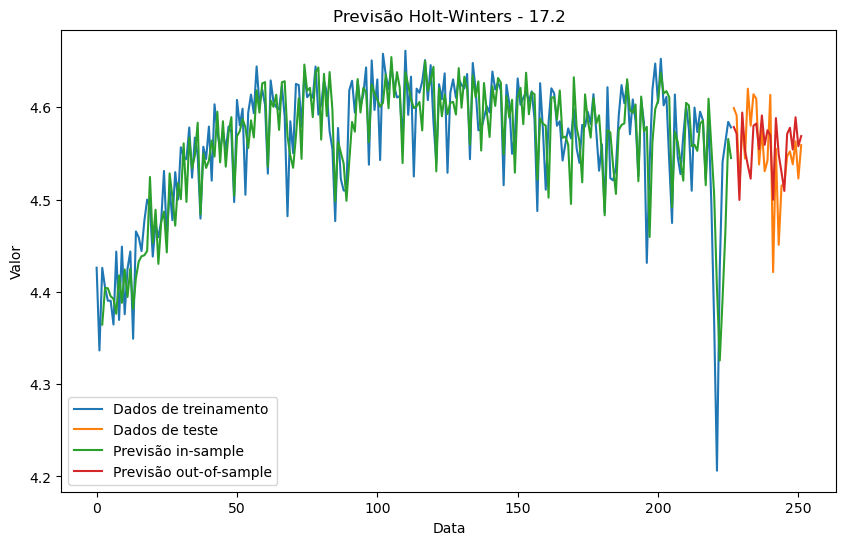

0.001548164037174878


c:\Users\alexa\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\alexa\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\alexa\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\alexa\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\alexa\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\alexa\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\U

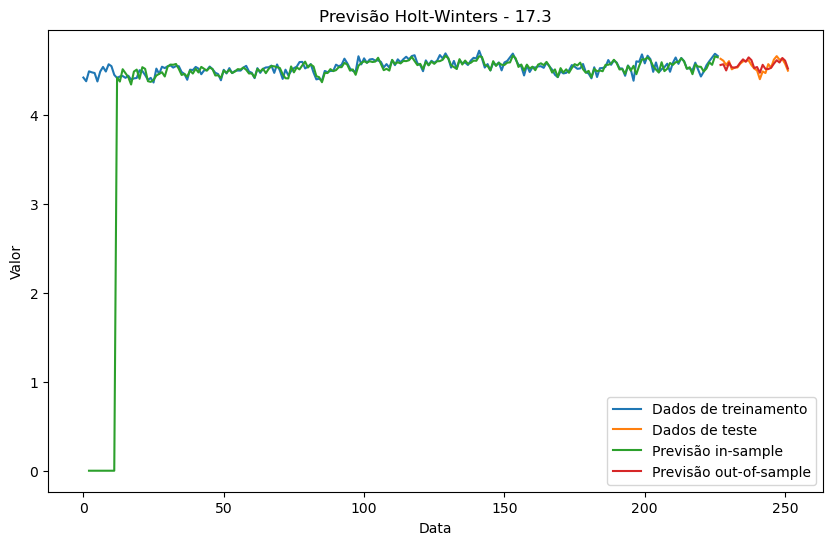

0.8990925622099211


c:\Users\alexa\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\alexa\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\alexa\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\alexa\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\alexa\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\alexa\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\U

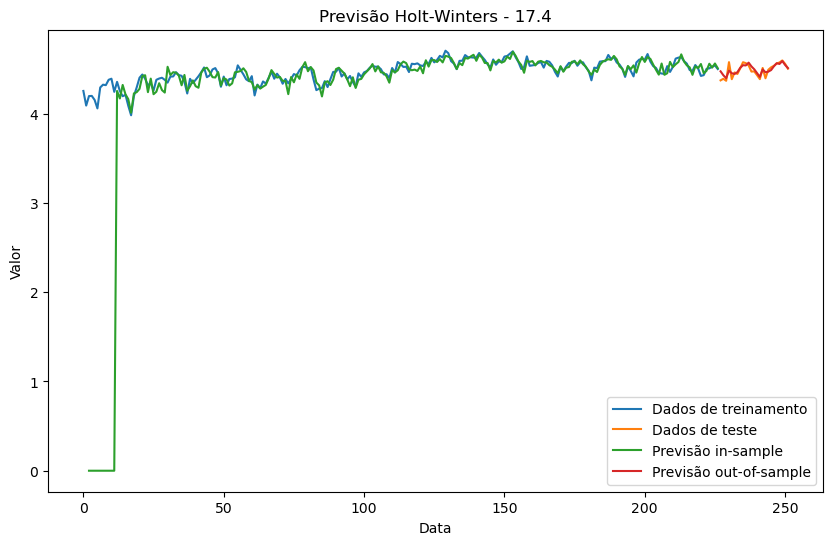

0.8078157196476159


,Setor,Best Metric,order,seasonal_order,Modelo,MSE_In-Sample,EQA_In-Sample,RMSE_In-Sample,RRMSE_In-Sample,MAE_In-Sample,MAPE_In-Sample,MSE_Out-of-Sample,EQA_Out-of-Sample,RMSE_Out-of-Sample,RRMSE_Out-of-Sample,MAE_Out-of-Sample,MAPE_Out-of-Sample
0,17.2,0.038086,"(1, 0, 1)","(2, 0, 2, 12)",<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,0.001548,0.348337,0.039347,0.008620,0.028664,0.006319,0.001523,0.038086,0.039031,0.008575,0.031041,0.006835
1,17.3,0.040910,"(2, 0, 0)","(0, 1, 1, 12)",<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,0.899093,202.295826,0.948205,0.208913,0.229373,0.050989,0.001636,0.040910,0.040453,0.008862,0.033954,0.007449
2,17.4,0.041143,"(1, 0, 1)","(2, 1, 1, 12)",<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,0.807816,181.758537,0.898786,0.201068,0.227800,0.053145,0.001646,0.041143,0.040567,0.009041,0.031105,0.006972


In [31]:
# SRM = SARIMA(tsa.df_macro_sectors.loc[:,['10.1']])
SRM = SARIMA(subset2)
result_df = SRM.select_best_sarima_model('eqa', 25) 
result_df

In [26]:
result_df

,Setor,Best Metric,order,seasonal_order,Modelo,MSE_In-Sample,EQA_In-Sample,RMSE_In-Sample,RRMSE_In-Sample,MAE_In-Sample,MAPE_In-Sample,MSE_Out-of-Sample,EQA_Out-of-Sample,RMSE_Out-of-Sample,RRMSE_Out-of-Sample,MAE_Out-of-Sample,MAPE_Out-of-Sample
0,10.1,0.040922,"(1, 1, 0)","(2, 1, 2, 12)",<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,0.023940,5.386431,0.154725,0.033539,0.048092,0.010476,0.001637,0.040922,0.040459,0.008715,0.030434,0.006565
1,10.3,0.602914,"(2, 1, 1)","(2, 0, 2, 12)",<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,0.040483,9.108704,0.201204,0.046433,0.145257,0.036305,0.024117,0.602914,0.155295,0.038341,0.111654,0.030583
2,10.4,0.042557,"(2, 1, 1)","(2, 0, 1, 12)",<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,0.004546,1.022827,0.067423,0.014602,0.046399,0.010155,0.001702,0.042557,0.041258,0.008787,0.030609,0.006571
3,10.5,0.064236,"(1, 1, 0)","(0, 1, 0, 12)",<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,0.026717,6.011288,0.163453,0.035781,0.057926,0.012647,0.002569,0.064236,0.050689,0.011630,0.043501,0.009984
4,10.6,0.027832,"(2, 1, 2)","(2, 0, 0, 12)",<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,0.001626,0.365795,0.040321,0.008811,0.030844,0.006754,0.001113,0.027832,0.033366,0.007254,0.028795,0.006260
5,10.7,1.641490,"(0, 1, 0)","(0, 1, 1, 12)",<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,0.090467,20.355137,0.300778,0.069052,0.208254,0.052671,0.065660,1.641490,0.256241,0.065303,0.184905,0.055646
6,10.8,0.117811,"(0, 1, 2)","(1, 1, 0, 12)",<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,0.025118,5.651447,0.158485,0.035195,0.064468,0.014751,0.004712,0.117811,0.068647,0.014786,0.056988,0.012233
7,11.1,0.124400,"(1, 0, 2)","(2, 0, 2, 12)",<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,0.008103,1.823179,0.090017,0.020021,0.055760,0.012602,0.004976,0.124400,0.070541,0.015250,0.059901,0.012916
8,11.2,0.172382,"(1, 0, 2)","(1, 0, 1, 12)",<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,0.005999,1.349718,0.077452,0.017520,0.055852,0.012751,0.006895,0.172382,0.083038,0.018211,0.069535,0.015273
9,13.1,0.488349,"(2, 1, 2)","(2, 1, 2, 12)",<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,0.030304,6.818431,0.174081,0.037122,0.056680,0.012234,0.019534,0.488349,0.139764,0.032823,0.119205,0.028177


In [23]:
forecast_errors_df = SRM.generate_forecast_errors()
forecast_errors_df

,Setor,h(período da previsão),MSE_In-Sample,EQA_In-Sample,RMSE_In-Sample,RRMSE_In-Sample,MAE_In-Sample,MAPE_In-Sample,MSE_Out-of-Sample,EQA_Out-of-Sample,RMSE_Out-of-Sample,MAE_Out-of-Sample,MAPE_Out-of-Sample,RRMSE_Out-of-Sample
0,10.1,1,0.023940,5.386431,0.154725,0.033548,0.048092,0.010476,0.000238,0.000238,0.015429,0.015429,0.003319,0.003319
1,10.1,6,0.023940,5.386431,0.154725,0.033548,0.048092,0.010476,0.000568,0.003407,0.023828,0.017232,0.003754,0.005173
2,10.1,9,0.023940,5.386431,0.154725,0.033548,0.048092,0.010476,0.000498,0.004486,0.022325,0.016743,0.003636,0.004830
3,10.1,12,0.023940,5.386431,0.154725,0.033548,0.048092,0.010476,0.001581,0.018977,0.039767,0.027769,0.006057,0.008617
4,10.3,1,0.040483,9.108704,0.201204,0.046474,0.145257,0.036305,0.000507,0.000507,0.022516,0.022516,0.005168,0.005168
5,10.3,6,0.040483,9.108704,0.201204,0.046474,0.145257,0.036305,0.061240,0.367439,0.247467,0.197655,0.061042,0.066942
6,10.3,9,0.040483,9.108704,0.201204,0.046474,0.145257,0.036305,0.044820,0.403380,0.211707,0.163081,0.047935,0.054245
7,10.3,12,0.040483,9.108704,0.201204,0.046474,0.145257,0.036305,0.039430,0.473156,0.198569,0.159889,0.044600,0.049427
8,10.4,1,0.004546,1.022827,0.067423,0.014618,0.046399,0.010155,0.000536,0.000536,0.023157,0.023157,0.005010,0.005010
9,10.4,6,0.004546,1.022827,0.067423,0.014618,0.046399,0.010155,0.003153,0.018920,0.056154,0.046549,0.010238,0.012139


In [24]:
result_df.to_excel('param_SARIMA_eqa_25_1-15.xlsx', index=False) 
forecast_errors_df.to_excel('Forecasting_SARIMA_eqa_1-15.xlsx', index=False) 